In [1]:
import numpy as np
import porepy as pp
from fpm_0 import make_model
from matplotlib import pyplot as plt

from mat_utils import *
from plot_utils import *
from pp_utils import make_row_col_dofs
from stats import LinearSolveStats, TimeStepStats

m1 = make_model()
m1.prepare_simulation()

m1.before_nonlinear_loop()
m1.before_nonlinear_iteration()

m1._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(m1)

m1.assemble_linear_system()
mat_1, rhs_1 = m1.linear_system
# model.linear_system = mat, rhs
perm_mat_1, prec_orig_1 = m1._prepare_solver()
x1 = m1.equation_system.get_variable_values(time_step_index=0)


/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [2]:
m2 = make_model(a=1)
m2.prepare_simulation()

m2.before_nonlinear_loop()
m2.before_nonlinear_iteration()

m2._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(m2)

m2.assemble_linear_system()
mat_2, rhs_2 = m2.linear_system
# model.linear_system = mat, rhs
perm_mat_2, prec_orig_2 = m2._prepare_solver()
x2 = m2.equation_system.get_variable_values(time_step_index=0)

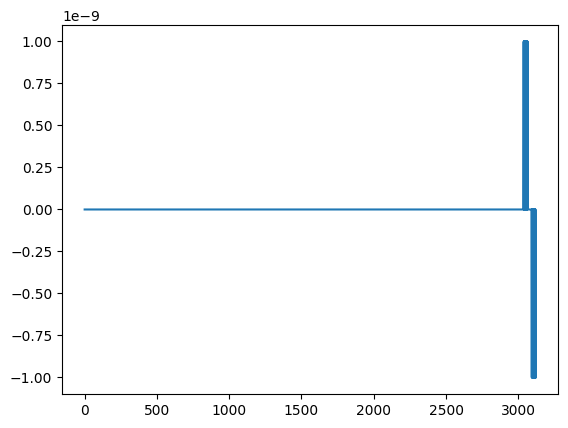

In [3]:
# %matplotlib widget
plt.plot((x1 - x2))
# plt.yscale('log')

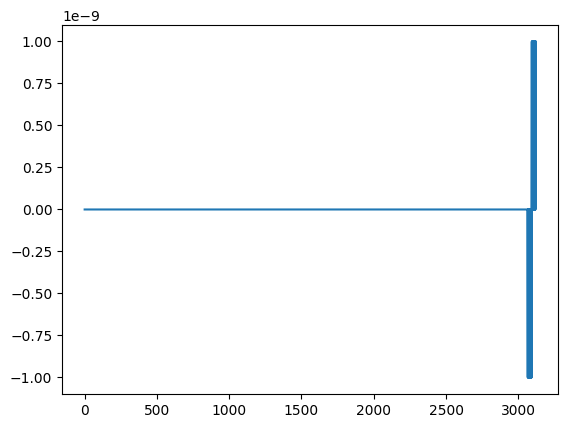

In [4]:
plt.plot(perm_mat_1.reverse_transform_solution(perm_mat_1.local_rhs(x1)) - x1)

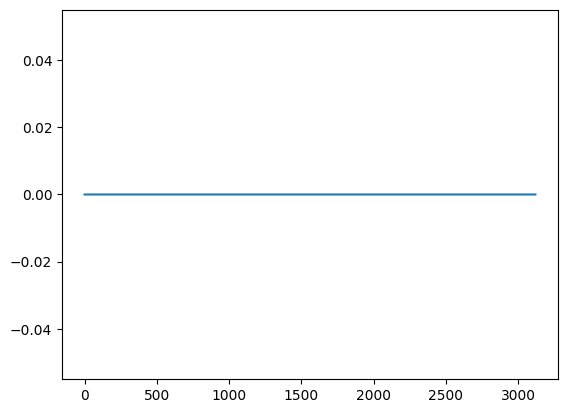

In [5]:
plt.plot(perm_mat_2.reverse_transform_solution(perm_mat_2.local_rhs(x2)) - x2)

In [7]:
perm_x1 = PetscGMRES(perm_mat_1.mat, pc=prec_orig_1).solve(perm_mat_1.local_rhs(rhs_1))
perm_x2 = PetscGMRES(perm_mat_2.mat, pc=prec_orig_2).solve(perm_mat_2.local_rhs(rhs_2))
abs(perm_x1 - perm_x2).max()

0.0

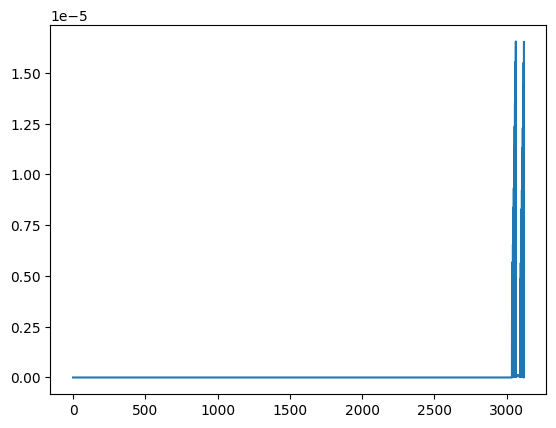

In [11]:
plt.plot(abs(perm_mat_1.reverse_transform_solution(perm_x1) - perm_mat_2.reverse_transform_solution(perm_x2)))

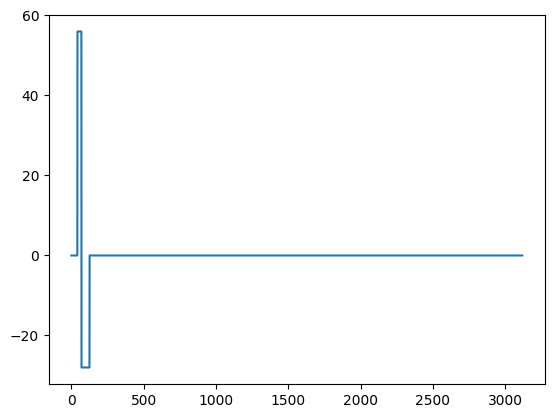

In [4]:
plt.plot(perm_mat_1.local_rhs(rhs_test) - perm_mat_2.local_rhs(rhs_test))

In [32]:
abs(
    perm_mat_1.reverse_transform_solution(perm_mat_1.local_rhs(rhs_test))
    - perm_mat_2.reverse_transform_solution(perm_mat_2.local_rhs(rhs_test))
).max()

0

In [35]:
perm_mat_1.active_groups

((3, 2, 4, 5, 1, 0), (3, 2, 4, 5, 1, 0))

In [34]:
perm_mat_2.active_groups

((3, 2, 4, 5, 1, 0), (3, 2, 4, 5, 1, 0))

Solve  took: 0.13


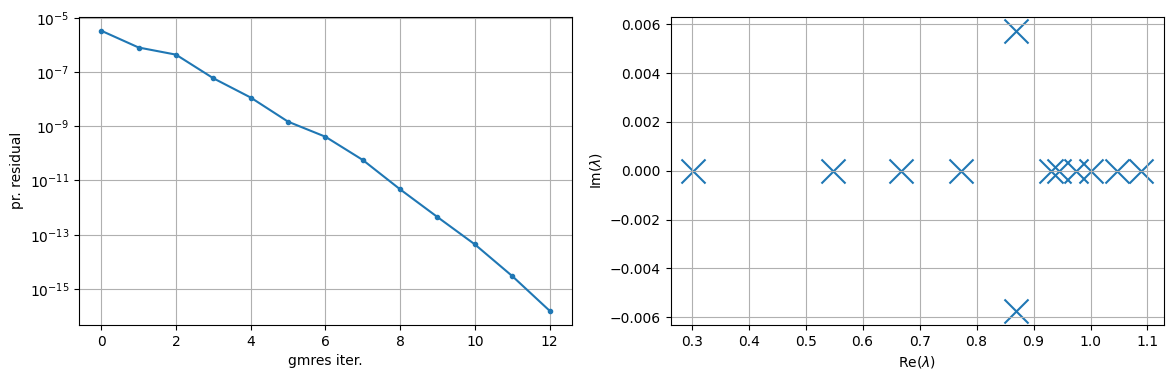

In [6]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

In [7]:
from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(
    mat=mat,
    row_idx=m1.eq_dofs,
    col_idx=m1.var_dofs,
    groups_row=m1._equation_groups,
    groups_col=m1._variable_groups,
)
# J[[3, 2, 4, 5], [3, 2, 4, 5]].color_spy()

In [8]:
J.active_groups

((0, 2, 3, 1, 4, 5), (0, 2, 3, 1, 5, 4))

In [9]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_fixed_stress = SolveSchema(
    # compute_cond=True,

    groups=[1],
    # invertor=lambda: get_fixed_stress_stabilization(model),
    # invertor_type="physical",
    invertor='direct',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),

    # solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    solve='direct',
    # solve=lambda bmat: PetscILU(bmat.mat),
    complement=SolveSchema(
        # compute_cond=True,
        groups=[0],
        solve='direct',
        # solve=lambda bmat: PetscAMGFlow(mat=bmat.mat),
    ),
)

# schema_baseline = SolveSchema(
#     groups=[2, 3, 4, 5],
#     complement=schema_fixed_stress,
#     compute_cond=True,
#     # color_spy=True,
# )

# mat_permuted, prec = make_solver(schema=schema_fixed_stress, mat_orig=J)
# mat_permuted, prec = make_solver(schema=schema_baseline, mat_orig=J)
# solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

In [10]:
schema_no_flow_intf = SolveSchema(
    # color_spy=True,
    compute_cond=True,
    groups=[2, 4, 5],
    complement=schema_fixed_stress,

    # solve=lambda bmat: PetscJacobi(bmat.mat),
    # invertor='direct',
)

schema_1 = SolveSchema(
    compute_cond=True,
    groups=[3],
    # solve=lambda bmat: PetscILU(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    
    # solve=lambda bmat: PetscGMRES(bmat.mat, pc=PetscILU(bmat.mat)),
    invertor='direct',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=schema_no_flow_intf,
)

mat_permuted, prec = make_solver(schema=schema_1, mat_orig=J)
# solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Blocks: (3,) cond: 2.11e+00
Blocks: (2, 4, 5) cond: 1.32e+13


In [11]:
rhs = np

((3, 2, 4, 5, 1, 0), (3, 2, 4, 5, 1, 0))